# Speech Commands recognition using ConvNets in PyTorch (Tutorial)

This is a tutorial post on speech commands recognition using the [Speech Commands dataset](https://arxiv.org/abs/1804.03209). The goals for this post  

1. Work with audio data using torchaudio: look at spectrograms features and data augmentation
2. Train a model to recogize audio data from a vocabulary of spoken commands
3. Evaluate model performance using measures like accuracy (error rate) and confusion matrix

There are around 10 speech commands like Yes, No, Up, Down and so on. The dataset contains wav files sampled at 16000 Hz and each command waveform contains upto a second of data. In addition to the commands themselves, there are some words that are not commands (and phonetically diverse) and background files containing background noise and silence segments. 

We will rely heavily on the torchaudio package for input preprocessing. It has some convenient dataloaders and feature preprocessing transforms. The nice thing about torchaudio, is that the feature processing can take place on the GPU and this will accelerate the training process significantly. 

To install torchaudio, the command below should be executed in a terminal:  
conda install -c pytorch torchaudio

The -c option searches on the pytorch channel.  

This notebook is available on github at this [link].(https://github.com/jumpml/pytorch-tutorials/blob/master/SpeechCommands_CNN.ipynb)

In [1]:
# CUSTOMARY IMPORTS
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from jumpml import SpeechCommandsDataset as scd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
%matplotlib inline

random_seed = 1        
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/ragh/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
torch.cuda.is_available()

True

## Data  Setup

We have created a wrapper around torchaudio's SPEECHCOMMANDS dataset class. The wrapper performs the following steps for us  
1. Create train, val and test splits of the dataset 
2. Process the background noise files and creates 1 sec segments for augmenting each split
3. Pad the data to 1s and map the string labels to integer. Number 11 corresponds to background or unknown. 
4. Creates dataloaders for each split with appropriate transforms (MelSpectrogram, etc.)

The torchaudio class automatically downloads the data if not already on disk. If we look at the source code for the speechcommands dataset class in torchaudio, we need to specify the version of speech commands (v0.2). The dataset is around 2.3GB in size. Each item in the dataloader consists of the following information:  
waveform, sample_rate, label, speaker_id, utterance_number. 

In this tutorial, we are not using speaker_id or utterance_number. We are not downsampling the audio to 8kHz, which may be a good thing to do, since it is an effective way to throw away information that is not related to the task of recognizing commands. Most of the voice information is between 20 Hz to 3.6 kHz. 

### Feature Pre-Processing
Torchaudio comes with several useful [transforms](https://pytorch.org/audio/transforms.html), which we can use to get our input features efficiently computed on GPU. 

Here is the feature processing we use for training data
```python
self.train_transform = torch.nn.Sequential(
   torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=320, hop_length=160, n_mels=n_mels),
   torchaudio.transforms.FrequencyMasking(freq_mask_param=int(n_mels*0.2)),
   torchaudio.transforms.TimeMasking(time_mask_param=int(0.2 * 16000/160)),
   torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80))
```

A spectrogram is used to map the a waveform to a time-frequency representation which is almost always used in any kind of speech processing. We use a hop length of 10ms and a FFT size of 20 ms. In order to keep our inputs small, we also employ mel filterbanks to get 64 features in total. Then we convert the spectrogram magnitude to log-power scale in dB with a minimum floor of -80 dB. In order to get more general features, we additionally apply Frequency and Time masking on the training set only. 



In [3]:
batch_size_train = 64
# Setup train, val and test dataloaders
sc_data = scd.SpeechCommandsData(train_bs=batch_size_train, test_bs=256, val_bs=256, n_mels=64)

Found existing background directory. Removing files in that directory.
Initialize/download SpeechCommandsDataset....

SpeechCommands Dataset Size: 105829

Generate 1s background files:

Background files generated: 282

Extracting training dataset files...
Train dataset extracted: 84843 files 

Extracting test and val dataset files...
Validation dataset extracted: 9981 files
Test dataset extracted: 11005 files


/home/ragh/anaconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ragh/anaconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


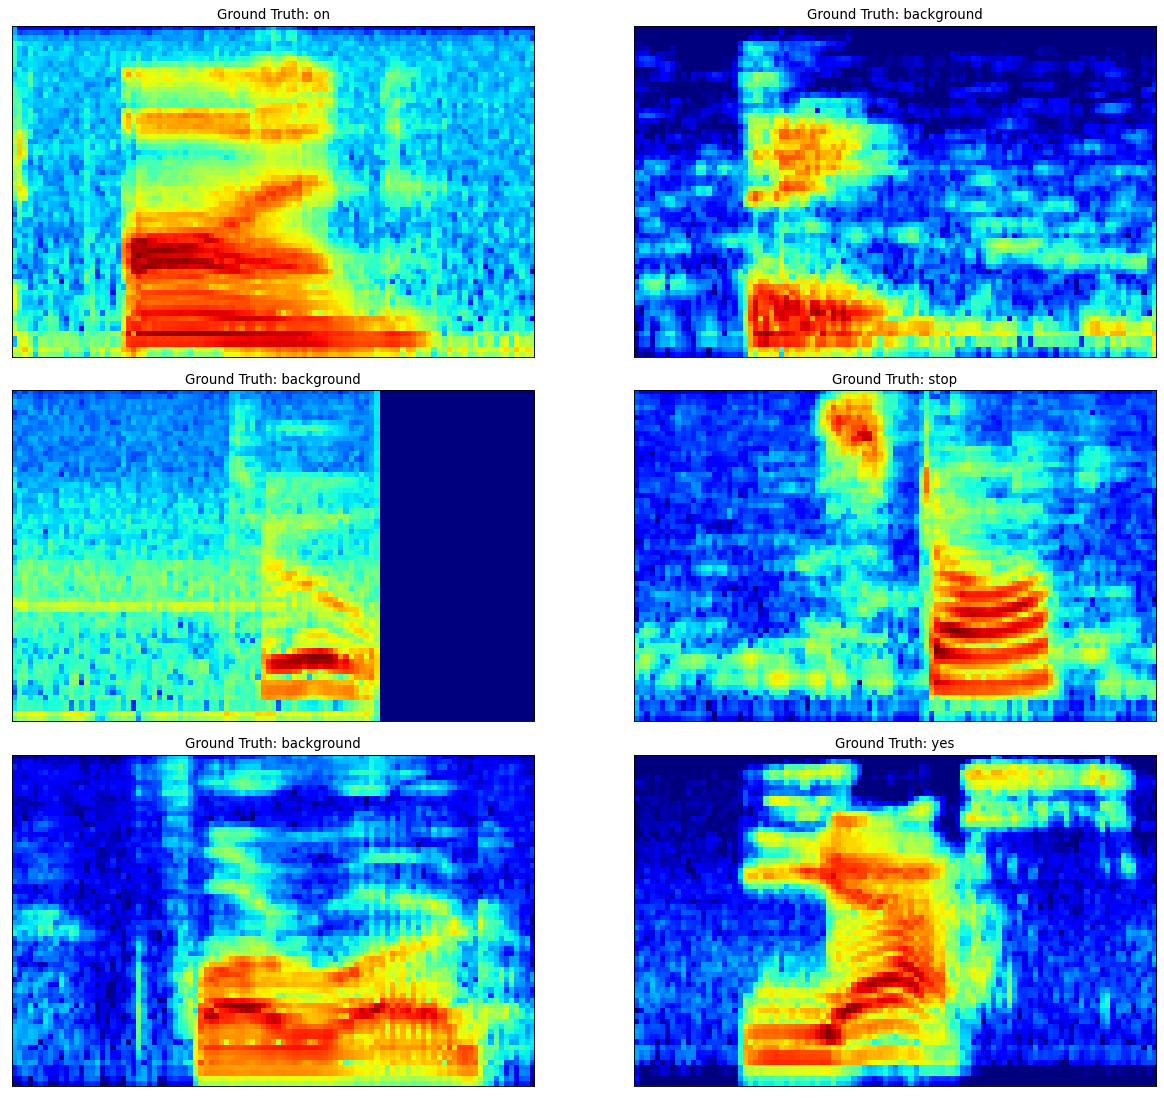

In [4]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
examples = enumerate(sc_data.test_loader)
batch_idx, (example_X, example_y) = next(examples)

# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(16, 14), dpi=80)
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(torch.squeeze(example_X[i]), cmap='jet', origin='lower')
  plt.title("Ground Truth: {}".format(scd.KNOWN_COMMANDS[int(example_y[i])]))
  plt.xticks([])
  plt.yticks([])

In [5]:
example_X.shape
freq_dim = int(example_X.shape[2])
time_dim = int(example_X.shape[3])

## Model Specification

The model we use is not too complicated:   
Input X (B,1,64,101)  
--> 32 Conv2D(8,20) --> BatchNorm2D --> MaxPool2D(2) --> ReLU  
--> 8 Conv2D(4,10)  --> BatchNorm2D --> MaxPool2D(2) --> ReLU  
--> Linear(128)     --> BatchNorm1D                  --> ReLU  
--> Linear(11)                                       --> LogSoftmax  


where B is Batch Size, the arguments to Conv2D are input numChannels, output numChannels and kernel size.

In [6]:
def get_conv_size(in_dim, kernel_size, stride=1, padding=0, dilation=1):
    return ( (in_dim + 2*padding - dilation * (kernel_size - 1) - 1) // stride  + 1)

In [7]:
input_size = (freq_dim,time_dim)    # Spectrogram has 40 x 101 input images
C1_kernel_size = (8,20) # Customary to use odd and square kernel/filter size fxf 
num_filters_conv1 = 32
num_filters_conv2 = 8
C2_kernel_size = (4,10) # Customary to use odd and square kernel/filter size fxf 
mp2d_size = 2      # MaxPooling2d window size (= stride)
fc1_out_size = 128
fc2_out_size = 11  # 10 commands and 1 background class

C1 = (get_conv_size(input_size[0], C1_kernel_size[0]), 
      get_conv_size(input_size[1], C1_kernel_size[1]))         # C1: size after conv1 
MP1 = (get_conv_size(C1[0], mp2d_size, stride = mp2d_size),
       get_conv_size(C1[1], mp2d_size, stride = mp2d_size)) # MP1: size after max_pool2d
C2 = (get_conv_size(MP1[0], C2_kernel_size[0]),
       get_conv_size(MP1[1], C2_kernel_size[1]))               # C2: size after conv2 
MP2 = (get_conv_size(C2[0], mp2d_size, stride = mp2d_size),
       get_conv_size(C2[1], mp2d_size, stride = mp2d_size)) # MP2: size after max_pool2d
fc1_in_size = MP2[0]*MP2[1] * num_filters_conv2                   # pixels * num_filters

print(f'C1:{C1} MP1:{MP1}   C2:{C2} MP2:{MP2}    FC1_in:{fc1_in_size}')

C1:(57, 82) MP1:(28, 41)   C2:(25, 32) MP2:(12, 16)    FC1_in:1536


In [10]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters_conv1, kernel_size=C1_kernel_size)
        self.bn1   = nn.BatchNorm2d(num_filters_conv1)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, C2_kernel_size)
        self.bn2   = nn.BatchNorm2d(num_filters_conv2)
        self.fc1 = nn.Linear(fc1_in_size, fc1_out_size)
        self.fc2 = nn.Linear(fc1_out_size, fc2_out_size)           # number of classes = 11

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), mp2d_size))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), mp2d_size))
        x = x.view(-1, fc1_in_size)    # reshape
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)  # Apply dropout only during training
        out = self.fc2(x)
        return F.log_softmax(out, dim=1)

nnModel = model().to(device)       # Instantiate our model and move model to GPU if available

In [11]:
model_parameters = filter(lambda p: p.requires_grad, nnModel.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Model size: {params} parameters' )

Model size: 213635 parameters


## Objective or Loss Function
In the model the final layer is a log-softmax function, in other words, we get a vector of per-utterance log probabilities or log-likelihoods. So the output of the model is basically 
$$ \hat{y} = \log P(y | x) $$

If we combine this with the nll_loss, which stands for negative log-likelihood loss which basically does the following operation  
$$
l(\hat{y},y) = -\hat{y}[y]
$$

where $y$ is the true class label in ${0,1,...,C-1}$. If the model predicted the correct command with probability 1.0, then this loss would be 0.0. Otherwise it would be a positive number. By combining log-softmax and NLL loss, we get the Cross Entropy Loss. 

In [12]:
# Define objective function
lossFn = F.nll_loss  #When we combine nll_loss and log_softmax we get a cross entropy loss

## Model Optimization or Training 
The new parameters are the previous parameters with a step (proportional to learning rate $\mu$) in the direction (negative gradient of loss function w.r.t parameters) that reduces the loss function. In terms of math for a single labeled example $y$ and model prediction $\hat{y}$  
$$ W_n = W_{n-1} - \mu \nabla_{W} l(\hat{y},y) $$

For a batch of examples, we simply replace the loss above with some reduction such as the mean loss over the batch.

We will also apply **learning rate decay** on the initial learning rate. The StepLR function will apply a decay of $\gamma$ every step_size number of epochs to the exisiting learning rate in the optimizer. 


In [13]:
learning_rate = 0.1   # Learning rate for optimizer like SGD usually in [0.001, 0.1]
# Define optimization
optimizer = optim.SGD(nnModel.parameters(), lr=learning_rate, momentum=0.5)

# Apply decaying Learning Rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

## Mechanics of Training
Basically has the following steps which we repeat until all batches of training data are consumed
1. Get a batch of inputs (X) and corresponding labels (y), move to device
2. Initialize gradients
3. Calculate loss function on current batch of inputs and labels
4. Calculate gradients by calling backward() on the loss function output
5. Update parameters by calling optimizer.step()

At the start of end of each epoch (when one complete round of training data has been used), the learning rate is decayed. 

In [14]:
train_losses = []
TrainLen = len(sc_data.train_loader.dataset)
def train(model, lossFn, optimizer, train_loader, log_frequency=100):
  model.train()
  for batch_idx, (X_train, y_train) in enumerate(train_loader):
    # Move to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    # Initialize gradients
    optimizer.zero_grad()
    # Predict on current batch of data
    y_hat = model(X_train)
    # Calculate Average Loss
    loss = lossFn(y_hat, y_train)
    # Calculate Gradients
    loss.backward()
    # Update model parameters using SGD
    optimizer.step()
    if batch_idx % log_frequency == 0:
      print(f'Train  {batch_idx * len(X_train)}/{TrainLen} Loss:{loss.item()}\n')
      train_losses.append(loss.item())
  
  scheduler.step() # update learning rate for next call to train()
  




In [15]:
def evalModel(model, lossFn, dataloader, losses, mode='Val'):
  model.eval()
  loss = 0
  correct = 0
  predictions = torch.tensor([])
  labels = torch.tensor([])
  with torch.no_grad():
    for X_test, y_test in dataloader:
      labels = torch.cat((labels, y_test),dim=0)
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_hat = model(X_test)
      loss += lossFn(y_hat, y_test).item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      predictions = torch.cat((predictions, pred.cpu()),dim=0)
      correct += pred.eq(y_test.data.view_as(pred)).sum()
  loss /= len(dataloader.dataset)
  losses.append(loss)
  accuracy = 100. * correct / len(dataloader.dataset)
  print(f'\n{mode} set: Avg. loss: {loss:.4f}, Accuracy: {accuracy} %\n')
  cm = confusion_matrix(predictions.numpy(), labels.numpy())
  return(accuracy, cm)

## Let's Train

In [16]:
val_losses = []
n_epochs = 20
val_accuracy = np.zeros(n_epochs+1)
log_frequency=100
val_accuracy[0],_ = evalModel(nnModel, lossFn, sc_data.val_loader, val_losses)
for epoch in range(1, n_epochs + 1):
  print(f'Epoch-{epoch} lr: {optimizer.param_groups[0]["lr"]}')
  train(nnModel, lossFn, optimizer, sc_data.train_loader,log_frequency)
  val_accuracy[epoch],_ = evalModel(nnModel, lossFn, sc_data.val_loader, val_losses)
  
  


Val set: Avg. loss: 0.0104, Accuracy: 3.9072647094726562 %

Epoch-1 lr: 0.1
Train  0/85069 Loss:2.427880048751831

Train  6400/85069 Loss:1.7011605501174927

Train  12800/85069 Loss:1.4277939796447754

Train  19200/85069 Loss:1.1348835229873657

Train  25600/85069 Loss:0.9796842932701111

Train  32000/85069 Loss:0.9176626205444336

Train  38400/85069 Loss:0.8251010775566101

Train  44800/85069 Loss:0.849463939666748

Train  51200/85069 Loss:0.8081037402153015

Train  57600/85069 Loss:0.5789511203765869

Train  64000/85069 Loss:0.776586651802063

Train  70400/85069 Loss:0.41938474774360657

Train  76800/85069 Loss:0.7969487905502319

Train  83200/85069 Loss:0.5730145573616028


Val set: Avg. loss: 0.0030, Accuracy: 73.4186019897461 %

Epoch-2 lr: 0.1
Train  0/85069 Loss:0.5528607368469238

Train  6400/85069 Loss:0.6527256369590759

Train  12800/85069 Loss:0.7096179127693176

Train  19200/85069 Loss:0.49312159419059753

Train  25600/85069 Loss:0.7043830752372742

Train  32000/85069 Loss

Train  76800/85069 Loss:0.16454483568668365

Train  83200/85069 Loss:0.19415399432182312


Val set: Avg. loss: 0.0007, Accuracy: 93.97421264648438 %

Epoch-13 lr: 0.00625
Train  0/85069 Loss:0.2986060678958893

Train  6400/85069 Loss:0.21178816258907318

Train  12800/85069 Loss:0.2586023211479187

Train  19200/85069 Loss:0.5944947600364685

Train  25600/85069 Loss:0.21437327563762665

Train  32000/85069 Loss:0.17968501150608063

Train  38400/85069 Loss:0.2529425024986267

Train  44800/85069 Loss:0.14407095313072205

Train  51200/85069 Loss:0.11510241031646729

Train  57600/85069 Loss:0.19697317481040955

Train  64000/85069 Loss:0.2419014573097229

Train  70400/85069 Loss:0.30994296073913574

Train  76800/85069 Loss:0.26903027296066284

Train  83200/85069 Loss:0.3723154664039612


Val set: Avg. loss: 0.0007, Accuracy: 94.03417205810547 %

Epoch-14 lr: 0.00625
Train  0/85069 Loss:0.3842993676662445

Train  6400/85069 Loss:0.20071028172969818

Train  12800/85069 Loss:0.1510130912065506

T

## Performance Evaluation
The train dataset was used to train the model. The validation dataset is used to see if our model is overfitting or not over epochs. The test set is only gets used once at the end of model training and any architecture or hyperparameter optimization. 


Text(0, 0.5, 'negative log likelihood loss')

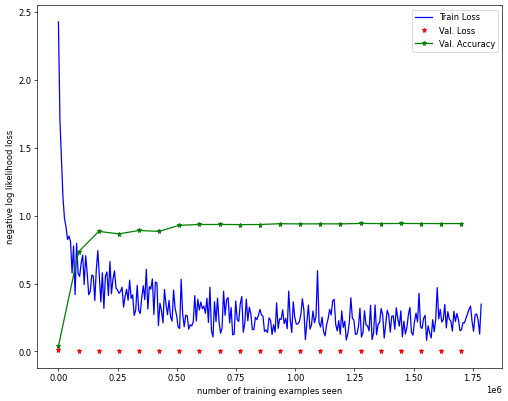

In [17]:
fig=plt.figure(figsize=(10, 8), dpi=60)
x = range(0,log_frequency*len(train_losses)*batch_size_train,log_frequency*batch_size_train)
plt.plot(x, train_losses, color='blue')
x = range(0, TrainLen*len(val_losses), TrainLen)
plt.plot(x,val_losses,'r*')
plt.plot(x,np.array(val_accuracy)/100.0,'g*-')
plt.legend(['Train Loss', 'Val. Loss', 'Val. Accuracy'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

As usual we will evaluate performance using accuracy rate, i.e. how many commands do we get correct on average. Another useful metric to look at is the confusion matrix, which tells us about how the model makes errors, when it makes errors. 

In [18]:
test_loss = []
accuracy, cm = evalModel(nnModel, lossFn, sc_data.test_loader, test_loss)
print(f'Test set accuracy = {accuracy}')
print(cm)


Val set: Avg. loss: 0.0008, Accuracy: 93.80097961425781 %

Test set accuracy = 93.80097961425781
[[ 399    0    0    0    1    0    0    0    0    1    5]
 [   0  328    0   16    0    0    0    0    0   22   19]
 [   1    1  370    0    0    0    1   16    4    1   17]
 [   0    8    0  338    1    0    3    0    1    5   18]
 [   2    0    0    1  369    3    0    0    0    2   22]
 [   0    0    0    0    1  352    0    0    0    0   19]
 [   0    0    1    0    0    0  326    9    0    0   21]
 [   0    0   10    0    0    0   18  347    0    3   13]
 [   0    1    6    0    1    0    0    2  390    2    5]
 [   1   23    0   11    0    0    0    3    1  329   19]
 [  16   44   38   40   39   41   48   25   15   37 6802]]


In [19]:
# Got this function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 399    0    0    0    1    0    0    0    0    1    5]
 [   0  328    0   16    0    0    0    0    0   22   19]
 [   1    1  370    0    0    0    1   16    4    1   17]
 [   0    8    0  338    1    0    3    0    1    5   18]
 [   2    0    0    1  369    3    0    0    0    2   22]
 [   0    0    0    0    1  352    0    0    0    0   19]
 [   0    0    1    0    0    0  326    9    0    0   21]
 [   0    0   10    0    0    0   18  347    0    3   13]
 [   0    1    6    0    1    0    0    2  390    2    5]
 [   1   23    0   11    0    0    0    3    1  329   19]
 [  16   44   38   40   39   41   48   25   15   37 6802]]


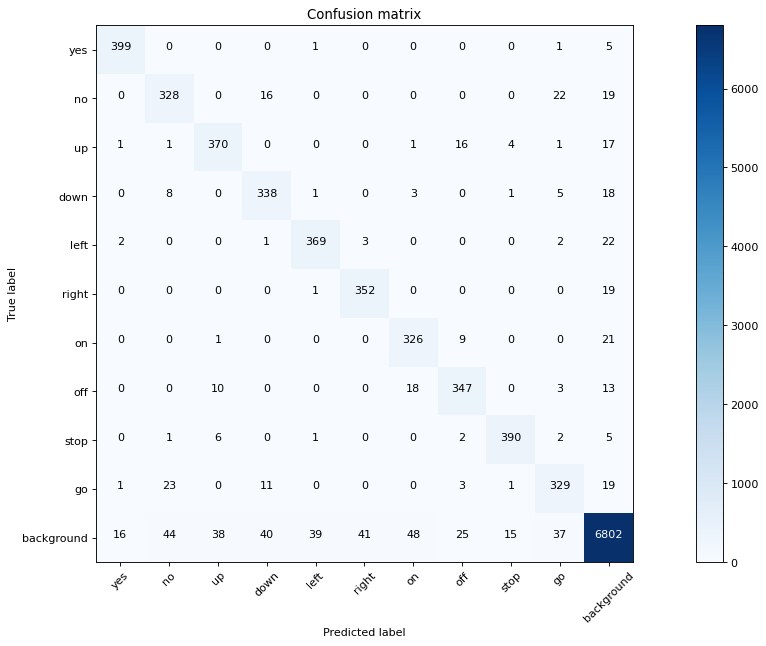

In [20]:
fig=plt.figure(figsize=(16, 8), dpi=80)
plot_confusion_matrix(cm, scd.KNOWN_COMMANDS)

In [21]:
torch.save(nnModel.state_dict(), 'models/speech_commands_model.pt')

## Final thoughts
We ended up with a final test accuracy of around 94.4% with our 200k parameter model. Seems not too shabby, considering that the baseline method in the [SpeechCommands paper](https://arxiv.org/pdf/1804.03209.pdf) results in an accuracy of 88.2% with the best model, which I think is referred to as *cnn-trad-fpool3* with 250k parameters. I'm not exactly sure since they don't explicitly mention those details in the paper and refer to another paper from 2015, which itself has more than a few models. 

#### Next steps to improve performance  
1. The idea of a background class seems a bit strange. It definitely makes the data balance off and model could cheat by just saying something is background
2. In background, we probably can differentiate between silence, noise (type of noise), speech, etc. This may result in better representations
3. Better model architecture: like ResNets, lower parameter count / complexity.
4. Better training: multi-task learning, self-supervised learning
5. Built in Denoising, Dereverb, Speaker Normalization

#### Wishlist
1. Use this model on my voice on real-time audio stream in a browser and study generalization on different microphones
2. Capability to train (finetune) the model in an online (supervised) fashion
3. Understanding model predictions and debug methods for misclassified examples



